<a href="https://colab.research.google.com/github/SidharthBhakth/Feedforward-NNs-in-pyTorch/blob/main/06_Compressing_NNs_with_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Compressing NNs with SVD**

# **Problem 1**

In [ ]:
# Import libraries

import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
plt.style.use('ggplot')

torch.manual_seed(0)

In [ ]:
# Check if GPU is available
print(torch.cuda.is_available())

# Set device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
cuda


In [ ]:
# Load MNIST data

# Train data
mnist_train = MNIST('mnist',
                    train=True,
                    download=True,
                    transform=transforms.Compose([transforms.ToTensor(),
                                                  transforms.Normalize((0.1307,), (0.3081,))]))


X_tr = (mnist_train.data).float().to(device)
Y_tr = (mnist_train.targets).long().to(device)
train_loader = DataLoader(TensorDataset(X_tr, Y_tr), batch_size = 500, shuffle = True)

# Test data
mnist_test = MNIST('mnist',
                    train=False,
                    download=True,
                    transform=transforms.Compose([transforms.ToTensor(),
                                                  transforms.Normalize((0.1307,), (0.3081,))]))

X_te = (mnist_test.data).float().to(device)
Y_te = (mnist_test.targets).long().to(device)
test_loader = DataLoader(TensorDataset(X_te, Y_te), batch_size = 500, shuffle = True)

In [ ]:
# Define a neural network architecture with 5 hidden layers of 1024 neurons per layer

class BaselineNN(nn.Module):
  def __init__(self):
    super(BaselineNN, self).__init__()

    self.fc1 = nn.Linear(784, 1024)
    self.fc2 = nn.Linear(1024, 1024)
    self.fc3 = nn.Linear(1024, 1024)
    self.fc4 = nn.Linear(1024, 1024)
    self.fc5 = nn.Linear(1024, 1024)
    self.fc6 = nn.Linear(1024, 10)
  
  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = F.log_softmax(self.fc6(x), dim = 1)
    
    return x

# def init_xavier(m):
#     if type(m) == nn.Linear:
#         nn.init.xavier_normal_(m.weight)
#         m.bias.data.fill_(0.01)

# Initilize NN class
NN = BaselineNN()
NN.to(device)

BaselineNN(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (fc6): Linear(in_features=1024, out_features=10, bias=True)
)

In [ ]:
def train(model = NN, lr = 0.001, n_epochs = 50, plot = True):

    # hyperparameters
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr)

    train_loss, train_accuracy = [], []

    for epoch in range(1, n_epochs+1):

        running_loss, running_acc = 0, 0

        # Train
        model.train()
        for X_tr, Y_tr in train_loader:
            optimizer.zero_grad()                                               # Set the parameter gradients to zero
            Y_pred = model(X_tr)                                                # Forward pass to predict
            loss = criterion(Y_pred, Y_tr)                                      # Compute loss on train data
            running_loss += loss.item()
            loss.backward()                                                     # Backpropagation
            optimizer.step()                                                    # Optimization

            Y_pred = torch.argmax(Y_pred, dim = 1)                              # For each 10-D output, find the dim with the maximum probability
            accuracy = 100 * (sum(Y_pred == Y_tr).item() / len(Y_tr))           # Compute accuracy on train data
            running_acc += accuracy
        
        # Keep track of train loss and accuracy for each epoch
        train_loss.append(running_loss/len(train_loader))
        train_accuracy.append(running_acc/len(train_loader))
    
        if epoch%10 == 0:
            print(f"Epoch {epoch:2} | train loss: {train_loss[-1]:.4f}, train accuracy: {train_accuracy[-1]:.2f}%")
    
    if plot:
        print("\n")
        fig, ax = plt.subplots(1, 2, figsize = (20,6))

        ax[0].plot(train_loss)
        ax[0].set_ylabel('Loss')
        ax[0].set_xlabel('Epochs')
        ax[0].set_title("Train Loss")

        ax[1].plot(train_accuracy)
        ax[1].set_ylabel('Accuracy')
        ax[1].set_xlabel('Epochs')
        ax[1].set_title("Train Accuracy");

Epoch 10 | train loss: 0.0255, train accuracy: 99.26%
Epoch 20 | train loss: 0.0140, train accuracy: 99.60%
Epoch 30 | train loss: 0.0123, train accuracy: 99.73%
Epoch 40 | train loss: 0.0068, train accuracy: 99.83%
Epoch 50 | train loss: 0.0132, train accuracy: 99.73%




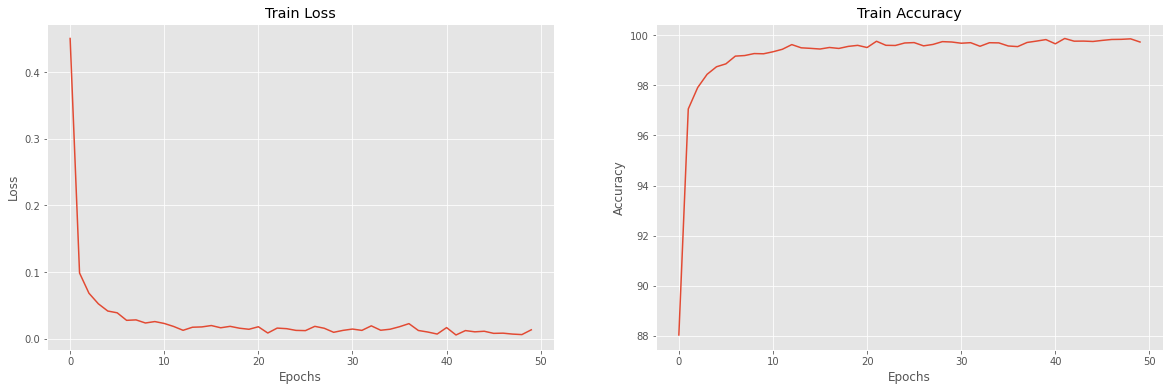

In [ ]:
train(model = NN,
      lr = 0.001,
      n_epochs = 50)

In [ ]:
def test(model = NN):

    test_accuracy = 0
    
    # Test
    model.eval()
    with torch.no_grad():
        for X_te, Y_te in test_loader:
            Y_pred = model(X_te)                                                # Forward pass to predict
            Y_pred = torch.argmax(Y_pred, dim = 1)                              # For each 10-D output, find the dim with the maximum probability
            accuracy = 100 * (sum(Y_pred == Y_te).item() / len(Y_te))           # Compute accuracy on test data
            test_accuracy += accuracy
    
    test_accuracy = test_accuracy/len(test_loader)
    
    print(f"Test accuracy: {test_accuracy:.2f}%")

    return test_accuracy

In [ ]:
_ = test(model = NN)

Test accuracy: 98.15%


In [ ]:
def compress(model = NN, singular_values = [10, 20, 50, 100, 200, 784]):

    # Get model weight matrices
    W1 = model.fc1.weight.data
    W2 = model.fc2.weight.data
    W3 = model.fc3.weight.data
    W4 = model.fc4.weight.data
    W5 = model.fc5.weight.data

    # Apply SVD to compress weights
    U1, S1, V1 = torch.svd(W1)
    U2, S2, V2 = torch.svd(W2)
    U3, S3, V3 = torch.svd(W3)
    U4, S4, V4 = torch.svd(W4)
    U5, S5, V5 = torch.svd(W5)

    test_accuracy = dict()

    for D in singular_values:

        # Calculate approximate weights
        W1_hat = U1[:,:D] @ torch.diag(S1[:D]) @ V1[:,:D].T
        W2_hat = U2[:,:D] @ torch.diag(S2[:D]) @ V2[:,:D].T
        W3_hat = U3[:,:D] @ torch.diag(S3[:D]) @ V3[:,:D].T
        W4_hat = U4[:,:D] @ torch.diag(S4[:D]) @ V4[:,:D].T
        W5_hat = U5[:,:D] @ torch.diag(S5[:D]) @ V5[:,:D].T

        # Load model state dictionary and modify weights
        state_dict = model.state_dict()

        state_dict['fc1.weight'] = W1_hat
        state_dict['fc2.weight'] = W2_hat
        state_dict['fc3.weight'] = W3_hat
        state_dict['fc4.weight'] = W4_hat
        state_dict['fc5.weight'] = W5_hat

        # Warmstart model with modified model weights
        model.load_state_dict(state_dict, strict=False)

        # Test
        print(f"Number of singular values used: {D}")
        test_accuracy[D] = test(model = NN)
        print("\n")

        del state_dict
    
    return test_accuracy

In [ ]:
test_accuracy = compress(model = NN,
                         singular_values = [10, 20, 50, 100, 200, 784])

Number of singular values used: 10
Test accuracy: 50.60%


Number of singular values used: 20
Test accuracy: 87.40%


Number of singular values used: 50
Test accuracy: 97.87%


Number of singular values used: 100
Test accuracy: 98.25%


Number of singular values used: 200
Test accuracy: 98.28%


Number of singular values used: 784
Test accuracy: 98.16%




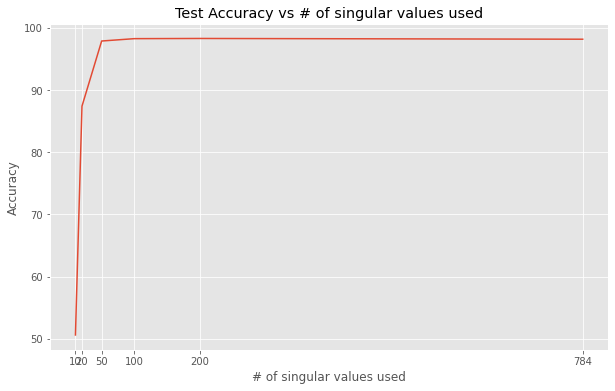

In [ ]:
D, accuracy = zip(*test_accuracy.items())

plt.figure(figsize = (10,6))
plt.plot(D, accuracy)
plt.ylabel('Accuracy')
plt.xlabel('# of singular values used')
plt.xticks(ticks = D)
plt.title("Test Accuracy vs # of singular values used");

# **Problem 2**

In [ ]:
class FactorizedNN(nn.Module):
    def __init__(self, input = 784, output = 10, hidden = 1024, D = 20):
        super(FactorizedNN, self).__init__()

        self.il = nn.Linear(input, D)

        self.U1 = nn.Linear(D, hidden)
        self.V1 = nn.Linear(hidden, D)

        self.U2 = nn.Linear(D, hidden)
        self.V2 = nn.Linear(hidden, D)

        self.U3 = nn.Linear(D, hidden)
        self.V3 = nn.Linear(hidden, D)

        self.U4 = nn.Linear(D, hidden)
        self.V4 = nn.Linear(hidden, D)

        self.ol = nn.Linear(D, output)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.il(x))
        x = F.relu(self.U1(x))
        x = F.relu(self.V1(x))
        x = F.relu(self.U2(x))
        x = F.relu(self.V2(x))
        x = F.relu(self.U3(x))
        x = F.relu(self.V3(x))
        x = F.relu(self.U4(x))
        x = F.relu(self.V4(x))
        x = F.log_softmax(self.ol(x), dim = 1)
    
        return x

# Initilize NN class
f_NN = FactorizedNN()
f_NN.to(device)

FactorizedNN(
  (il): Linear(in_features=784, out_features=20, bias=True)
  (U1): Linear(in_features=20, out_features=1024, bias=True)
  (V1): Linear(in_features=1024, out_features=20, bias=True)
  (U2): Linear(in_features=20, out_features=1024, bias=True)
  (V2): Linear(in_features=1024, out_features=20, bias=True)
  (U3): Linear(in_features=20, out_features=1024, bias=True)
  (V3): Linear(in_features=1024, out_features=20, bias=True)
  (U4): Linear(in_features=20, out_features=1024, bias=True)
  (V4): Linear(in_features=1024, out_features=20, bias=True)
  (ol): Linear(in_features=20, out_features=10, bias=True)
)

In [ ]:
def compress(model1 = NN, model2 = f_NN, singular_values = [20]):

    # Get model weight matrices
    W1 = model1.fc2.weight.data
    W2 = model1.fc3.weight.data
    W3 = model1.fc4.weight.data
    W4 = model1.fc5.weight.data

    # Apply SVD to compress weights
    U1, S1, V1 = torch.svd(W1)
    U2, S2, V2 = torch.svd(W2)
    U3, S3, V3 = torch.svd(W3)
    U4, S4, V4 = torch.svd(W4)

    for D in singular_values:

        # Calculate approximate weights
        U1, V1_T = U1[:,:D], torch.diag(S1[:D]) @ V1[:, :D].T
        U2, V2_T = U2[:,:D], torch.diag(S2[:D]) @ V2[:, :D].T
        U3, V3_T = U3[:,:D], torch.diag(S3[:D]) @ V3[:, :D].T
        U4, V4_T = U4[:,:D], torch.diag(S4[:D]) @ V4[:, :D].T

        # Load model state dictionary and modify weights
        state_dict = model2.state_dict()

        state_dict['U1.weight'] = U1
        state_dict['V1.weight'] = V1_T
        state_dict['U2.weight'] = U2
        state_dict['V2.weight'] = V2_T
        state_dict['U3.weight'] = U3
        state_dict['V3.weight'] = V3_T
        state_dict['U4.weight'] = U4
        state_dict['V4.weight'] = V4_T

        # Warmstart model with modified model weights
        model2.load_state_dict(state_dict, strict = False)

        # Train
        print("Training...")
        train(model = model2, lr = 0.00005, n_epochs = 50, plot = False)
        print("\n")

        # Test
        print("Testing...")
        print(f"Number of singular values used: {D}")
        _ = test(model = model2)

In [ ]:
compress(model1 = NN,
         model2 = f_NN,
         singular_values = [20])

Training...
Epoch 10 | train loss: 0.2290, train accuracy: 93.43%
Epoch 20 | train loss: 0.1308, train accuracy: 96.09%
Epoch 30 | train loss: 0.0899, train accuracy: 97.29%
Epoch 40 | train loss: 0.0638, train accuracy: 98.12%
Epoch 50 | train loss: 0.0468, train accuracy: 98.66%


Testing...
Number of singular values used: 20
Test accuracy: 96.26%


# **Problem 3**

In [ ]:
class CustomGrad(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        U, S, V = torch.svd(input)
        return U[:, :20] @ torch.diag(S[:20]) @ V[:, :20].T
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        return grad_input

In [ ]:
# Define a neural network architecture with 5 hidden layers of 1024 neurons per layer

class CustomGradNN(nn.Module):
  def __init__(self):
    super(CustomGradNN, self).__init__()

    self.fc1 = nn.Linear(784, 1024)
    self.fc2 = nn.Linear(1024, 1024)
    self.fc3 = nn.Linear(1024, 1024)
    self.fc4 = nn.Linear(1024, 1024)
    self.fc5 = nn.Linear(1024, 1024)
    self.fc6 = nn.Linear(1024, 10)

    self.grad = CustomGrad.apply
  
  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = F.relu(F.linear(x, self.grad(self.fc1.weight), self.fc1.bias))
    x = F.relu(F.linear(x, self.grad(self.fc2.weight), self.fc2.bias))
    x = F.relu(F.linear(x, self.grad(self.fc3.weight), self.fc3.bias))
    x = F.relu(F.linear(x, self.grad(self.fc4.weight), self.fc4.bias))
    x = F.relu(F.linear(x, self.grad(self.fc5.weight), self.fc5.bias))
    x = F.log_softmax(self.fc6(x), dim = 1)
    
    return x

# Initilize NN class
cust_NN = CustomGradNN()
cust_NN.load_state_dict(NN.state_dict(), strict = False)
cust_NN.to(device)

CustomGradNN(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (fc6): Linear(in_features=1024, out_features=10, bias=True)
)

Epoch 10 | train loss: 0.0642, train accuracy: 98.05%
Epoch 20 | train loss: 0.0567, train accuracy: 98.25%
Epoch 30 | train loss: 0.0566, train accuracy: 98.22%
Epoch 40 | train loss: 0.0509, train accuracy: 98.52%
Epoch 50 | train loss: 0.0496, train accuracy: 98.46%




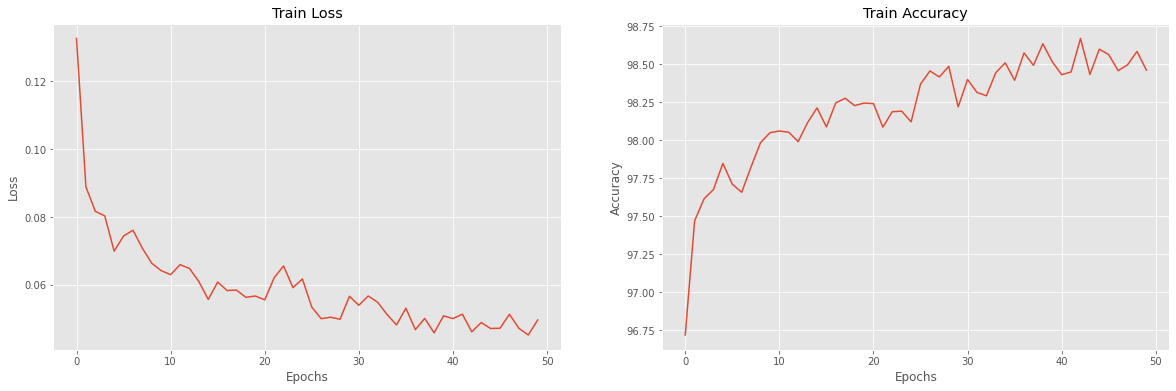

In [ ]:
train(model = cust_NN,
      lr = 0.001,
      n_epochs = 50)

In [ ]:
_ = test(model = cust_NN)

Test accuracy: 97.34%
